# Мэтчинг товаров

Цель проекта: Подобрать и обучить модель на исходных данных, способную найти 5 похожих товаров для валиадационной выборки из датасета base, основываясь на метрики accuracy@5.

Задачи:
- Загрузка датасетов и предварительный обзор;
- EDA;
- Построение Baseline-моделей и выбор наилучшего варианта;
- Предобработка данных перед обучением;
- Обучение модели и анализ результатов

Интерументы: В проекте использовались алгоритмы реализованные в библиотеки FAISS, обучение происходило на GPU.

In [ ]:
# %conda install -c pytorch faiss-cpu (если нет CUDA)
# %conda install -c conda-forge faiss-gpu

In [ ]:
# %conda install -c "conda-forge/label/broken" faiss-gpu

## Импорты и константы

### Импорты

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import faiss
import sweetviz as sv
import numpy as np
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

ModuleNotFoundError: No module named 'faiss'

### Константы

In [348]:
k_similar = 5 # Количество (соседей) похожих товаров

## Загрузка и обзор данных

In [349]:
train = pd.read_csv('./Data/train.csv', index_col=0) 
valid = pd.read_csv('./Data/validation.csv', index_col=0)
valid_awr = pd.read_csv('./Data/validation_answer.csv', index_col=0)
base = pd.read_csv('./Data/base.csv', index_col=0)

In [350]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
0,100000.000000,-85.328679,25.803845,-186.280270,-103.309147,-85.273695,-67.330810,14.585236
1,100000.000000,7.664345,4.955651,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.000000,-43.667046,39.111064,-224.896060,-69.494487,-42.830246,-17.713690,128.108460
3,100000.000000,-146.118630,20.434841,-223.307220,-160.028520,-146.067445,-132.277745,-60.751625
4,100000.000000,111.770592,47.700958,-93.272020,79.474322,112.260100,143.760830,301.363600
5,100000.000000,-73.178792,28.718853,-184.962450,-92.834080,-73.364420,-53.699612,51.849710
6,100000.000000,-440.615118,279.017550,-791.469482,-738.536868,-511.837758,-201.116578,109.625188
7,100000.000000,21.231588,65.985214,-278.582820,-22.131764,22.278989,65.899595,288.171840
8,100000.000000,123.067891,6.492081,94.831150,118.674642,123.087540,127.541802,149.356200
9,100000.000000,126.120201,64.912752,-142.156950,82.545028,125.963340,169.701005,392.827150


In [351]:
base.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
0,2918139.000000,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.000000,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.000000,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.000000,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.000000,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
5,2918139.000000,-71.991376,28.186068,-211.008600,-91.379940,-71.922300,-52.441105,58.806244
6,2918139.000000,-392.223854,271.654995,-791.469870,-629.331823,-422.201616,-156.668583,109.632533
7,2918139.000000,20.352829,64.216382,-301.859740,-22.221474,20.804773,63.918212,341.228200
8,2918139.000000,123.684234,6.356109,93.153046,119.483983,123.892250,127.970480,152.261200
9,2918139.000000,124.458053,64.430576,-173.871950,81.767510,123.497696,167.220605,427.542050


Сразу можно обратить внимание, что есть некоторые признаки, которые имеют сильный разброс по стандартному отклонению, этот фактор может являтся ключевым при обучении модели.

Датасет: Набор даннх имеет 72 признака, в Base имеется порядка 3 млн. записей, пропуски и дубликаты в данных отсутсвуют. Данные представленны ввиде вещественных чисел Float64.

In [352]:
d = base.shape[1] # Получим количество признаков
d

72

In [353]:
features_t = train.drop('Target', axis=1) # Из датасета Train возьмем признаки

Выполним явное преобразование типов данных в датасетах, для уменьшения занимаемого пространства

In [354]:
features_t = features_t.astype('float32')
valid = valid.astype('float32')
base = base.astype('float32')


In [ ]:
ngpu = 2 # Количество видеокарт

## EDA

Воспользуемся библиотекой `sweetviz` для быстрого анализа данных

In [356]:
train_report = sv.analyze(base)

                                             |          | [  0%]   00:00 -> (? left)

In [357]:
train_report.show_html('Base_report.html')

Report Base_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Baseline (FAISS)

Для решения задачи метчинага была выбрана одна из наиболее эффективных и популярных библитек от Facebook - FAISS. 

В работе исследованы модели `FlatL2` `IVF` `HNSW`.

### Flat L2

In [359]:
index = faiss.IndexFlatL2(d)
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)
index_gpu.add(base)

In [360]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [361]:
targets = train["Target"]

In [362]:
targets_v = valid_awr['Expected']

In [363]:
%%time
D, I = index_gpu.search(features_t, k_similar)
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.804

CPU times: total: 2.2 s

Wall time: 3.24 s


In [364]:
%%time
D, I = index_gpu.search(valid, k_similar)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.286

CPU times: total: 1.94 s

Wall time: 2.88 s


## IVF

In [365]:
nlist = 18

quant = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quant, d, nlist)

resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

index_gpu.train(base)
index_gpu.add(base)
index_gpu.nprobe = 8

In [366]:
%%time
D, I = index_gpu.search(features_t, k_similar)
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.676

CPU times: total: 14.2 s

Wall time: 21.7 s


In [367]:
%%time
D, I = index_gpu.search(valid, k_similar)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.155

CPU times: total: 17 s

Wall time: 21.4 s


## HNSW

In [404]:
index = faiss.IndexHNSWFlat(d, 1024)
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)
index_gpu.add(base)

In [405]:
%%time
D, I = index_gpu.search(features_t, k_similar)
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

11.895

CPU times: total: 49.7 s

Wall time: 3.11 s


In [406]:
%%time
D, I = index_gpu.search(valid, k_similar)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

11.431

CPU times: total: 49.2 s

Wall time: 2.32 s


### Результаты baseline

**Выбор модели**

Были рассмотрены три модели `FlatL2` `IVF` и `HNSW`. Для опеределения наилучшей модели была использована метрика accuracy@5 (среднее значение accuracy для 5 метчей).


**Обучение моделей**

Показатели метрик для валидационной выборки:
- `FlatL2`
    - Accuracy@5 `13.286`
- `IVF`
    - Accuracy@5 `13.155`
- `HNSW`
    - Accuracy@5 `11.431`

Далее будет использоваться модель **FlatL2**

## Предобработка данных

Проверим данные на нормальность (подчинению закону нормального расспределения); Проведем тест Шапиро-Уилка; Оценим параметр ассиметрии данных (skew); Выполним масштабирование данных.

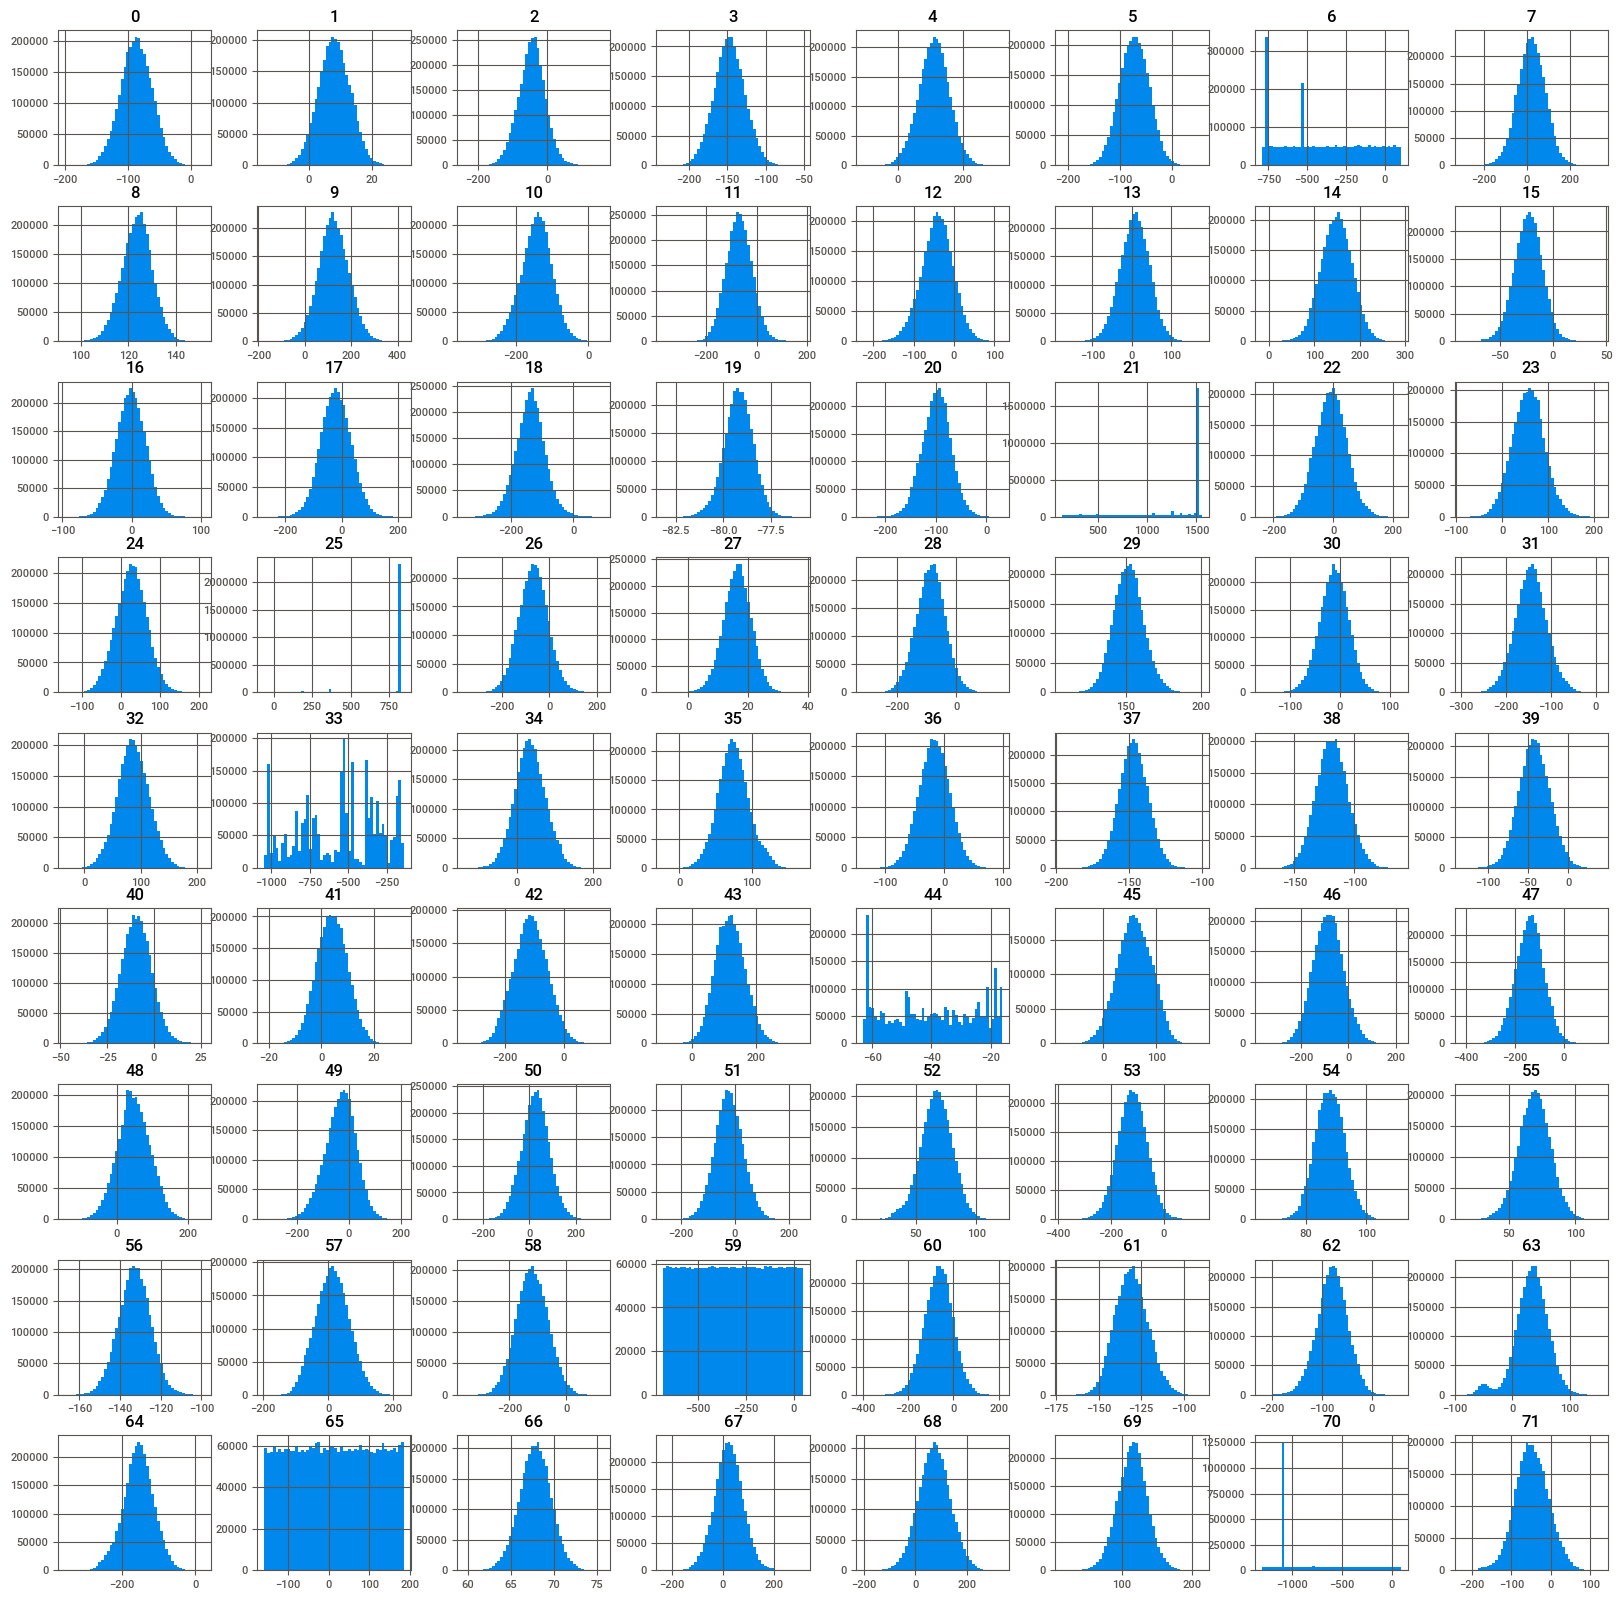

In [407]:
base.hist(figsize=[20, 20], bins=50);

### Тест Шапиро-Улка на нормальность данных

Отметим только те признаки которые попадают в интервал 3-х sigm, на небольшом отрезке данных (При величине вектора больше 5000, p-value будет работать нестабильно) 

In [408]:
from scipy.stats import shapiro 

def statistic(x):
    return shapiro(x).statistic

for i in base:
    if statistic(base[i][:5000]) <= 0.99:
        print(i, statistic(base[i][:5000]))

6 0.9250501990318298

21 0.6629842519760132

25 0.4638264775276184

33 0.9497290849685669

44 0.9321777820587158

59 0.9556774497032166

63 0.9880903363227844

65 0.9575280547142029

70 0.8518416881561279


### SKEW

In [411]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    return sum

s = summary(base)
s.style.background_gradient(cmap='Blues')

,dtypes,count,skew
0,float32,2918139,0.000744
1,float32,2918139,0.017557
2,float32,2918139,0.016011
3,float32,2918139,0.033701
4,float32,2918139,-0.034201
5,float32,2918139,-0.004667
6,float32,2918139,0.195861
7,float32,2918139,-0.063873
8,float32,2918139,-0.118099
9,float32,2918139,0.024290


In [412]:
s.query('skew > 0.5 or skew < -0.5')

,dtypes,count,skew
21,float32,2918139,-1.422238
25,float32,2918139,-2.344638
63,float32,2918139,-0.553200
70,float32,2918139,0.908481


Уберем из наших исходных данных признаки которые не подчиняются закону нормального расспределения

In [413]:
base_norm = base.drop(['6','21','25','33','44','59','63','65','70'], axis=1)
train_norm = train.drop(['6','21','25','33','44','59','63','65','70'], axis=1)
valid_norm = valid.drop(['6','21','25','33','44','59','63','65','70'], axis=1)

In [414]:
features_t_norm = train_norm.drop('Target', axis=1)

### Мультиколлениарность

Выполним проверку на мультиколлениарность данных

In [415]:
vif_data = pd.DataFrame()
vif_data["feature"] = base_norm.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(base_norm.values, i)
                          for i in range(len(base_norm.columns))]
  
print(vif_data)

   feature          VIF

0        0    13.343630

1        1     3.854731

2        2     2.400597

3        3    56.552427

4        4     6.922567

..     ...          ...

58      66  1312.926508

59      67     1.221793

60      68     2.584730

61      69    31.487181

62      71     2.418754



[63 rows x 2 columns]


In [416]:
VIF_features_drop = vif_data.query('VIF > 9.0')['feature']
VIF_features_drop

0      0
3      3
7      8
9     10
13    14
17    18
18    19
19    20
24    27
26    29
28    31
29    32
31    35
33    37
34    38
47    52
49    54
50    55
51    56
55    61
57    64
58    66
61    69
Name: feature, dtype: object

In [417]:
base_vif = base_norm.drop(VIF_features_drop.values, axis=1)
train_vif = train_norm.drop(VIF_features_drop.values, axis=1)
valid_vif = valid_norm.drop(VIF_features_drop.values, axis=1)

In [418]:
features_t_vif = train_vif.drop('Target', axis=1)

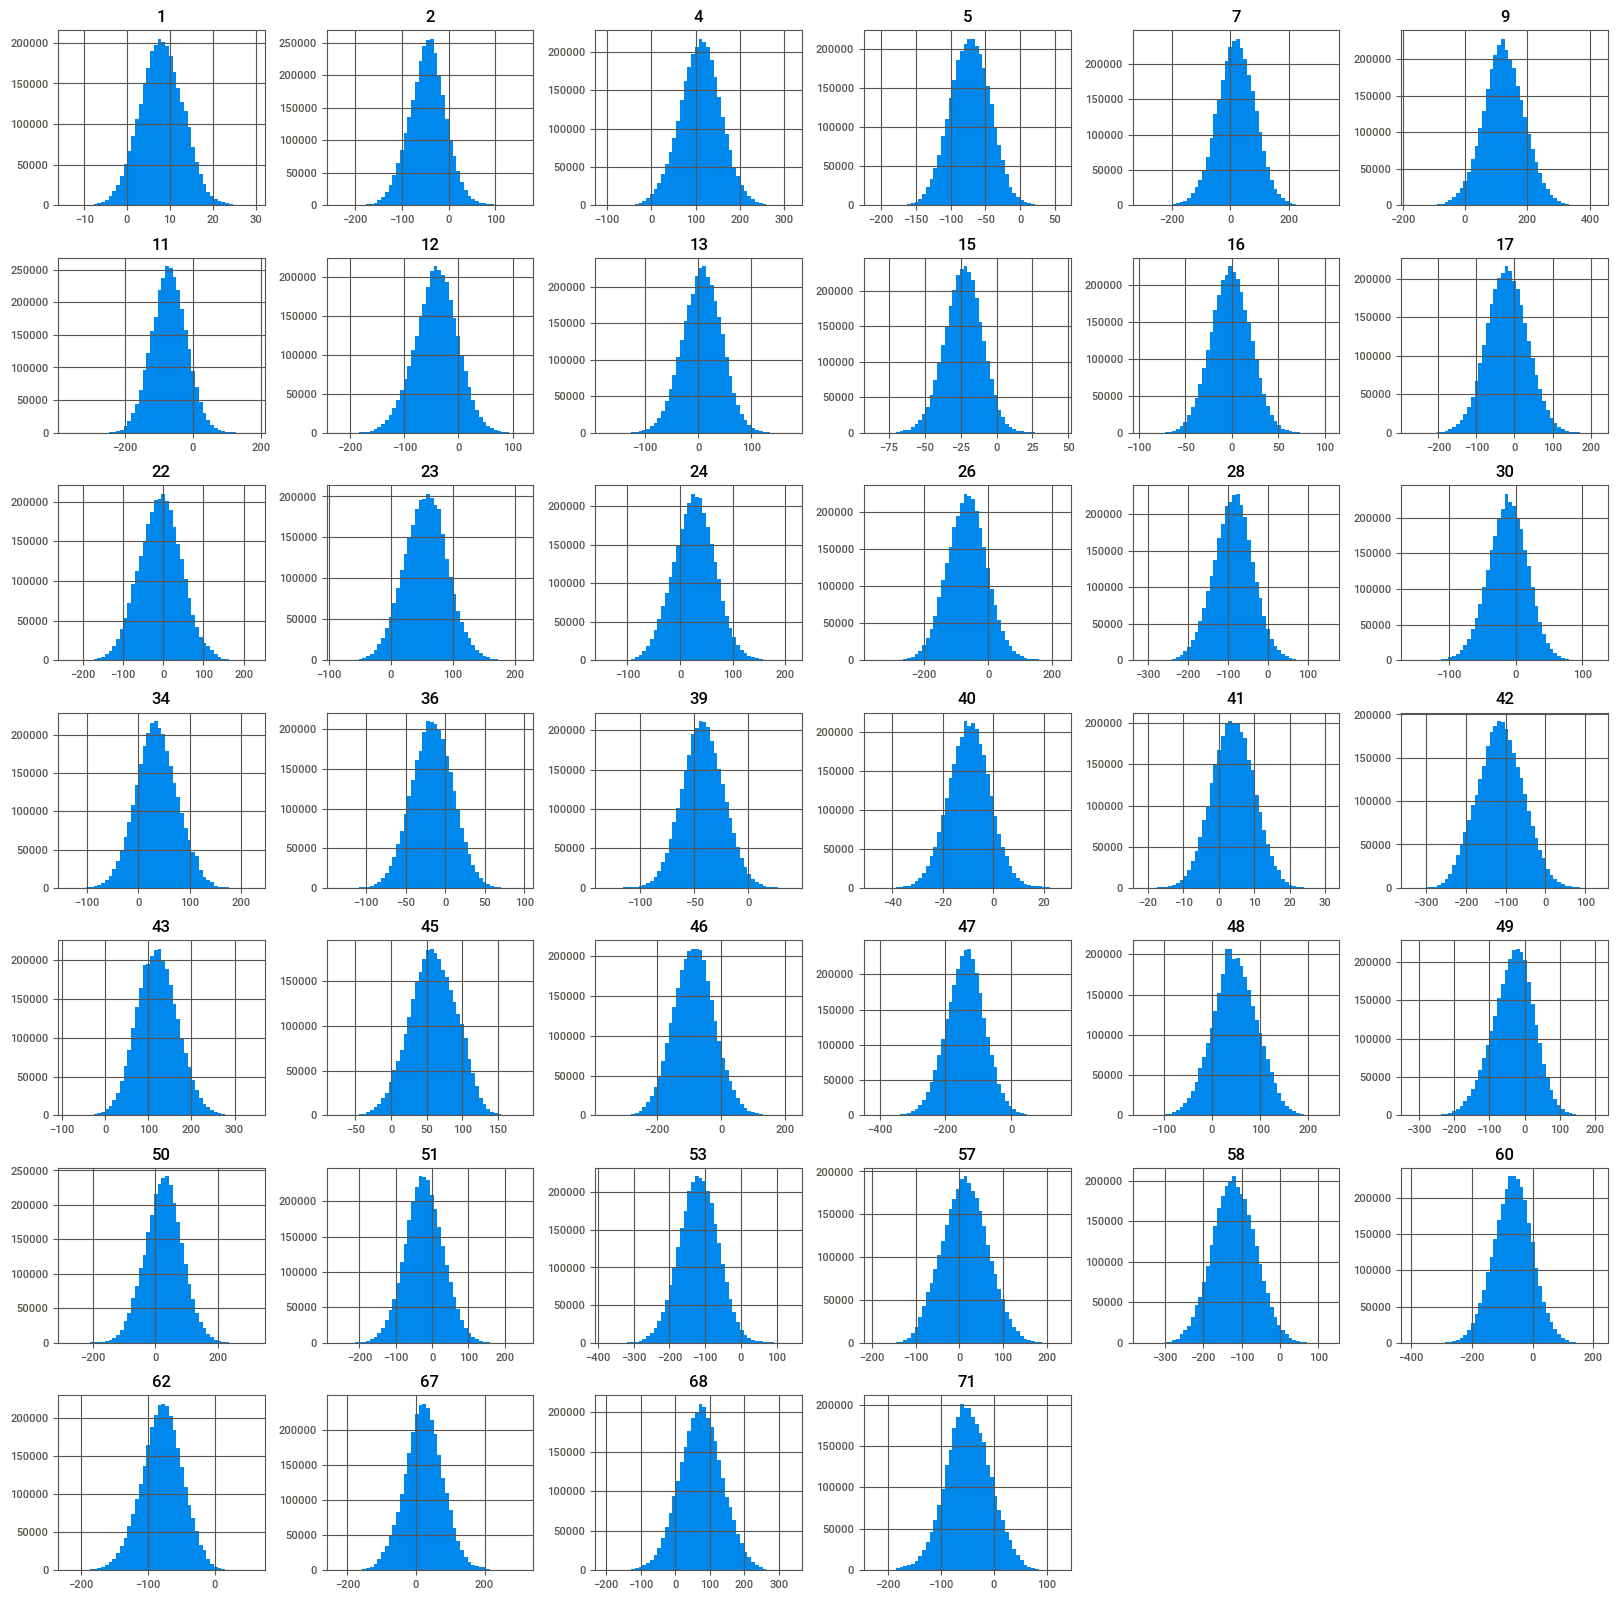

In [419]:
base_vif.hist(figsize=[20, 20], bins=50);

### Масштабирование 

In [423]:
scaler = RobustScaler()
base_slr_vif = scaler.fit_transform(base_vif)
features_slr_vif = scaler.transform(features_t_vif)
valid_slr_vif = scaler.transform(valid_vif)

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated a

## Обучение модели

In [424]:
d_vif = base_slr_vif.shape[1]

In [425]:
index = faiss.IndexFlatL2(d_vif)
index.add(base_slr_vif)

In [426]:
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

In [427]:
base_vif_index = {k: v for k, v in enumerate(base_vif.index.to_list())}

In [428]:
%%time
D, I = index_gpu.search(features_slr_vif, k_similar)
acc = 0
for target, el in zip(target_vif.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

69.702

CPU times: total: 1.69 s

Wall time: 3.04 s


In [429]:
%%time
D, I = index_gpu.search(valid_slr_vif, k_similar)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

69.569

CPU times: total: 1.98 s

Wall time: 2.77 s


## Выводы

Цель проекта было подобрать и обучить модель на исходных данных, способную найти 5 похожих товаров для валиадационной выборки из датасета base, основываясь на метрики accuracy@5.

Выполненые задачи:
- Загрузка датасетов и предварительный обзор;
- EDA;
- Построение Baseline-моделей и выбор наилучшего варианта;
- Предобработка данных перед обучением;
- Обучение модели и анализ результатов

Для решения задачи метчинага была выбрана одна из наиболее эффективных и популярных библитек от Facebook - FAISS. 

В работе исследованы модели `FlatL2` `IVF` и `HNSW`.

Показатели метрик для валидационной выборки:
- `FlatL2`
    - Accuracy@5 `13.286`
- `IVF`
    - Accuracy@5 `13.155`
- `HNSW`
    - Accuracy@5 `11.431`

Далее использовалась модель **FlatL2**

Итоговые результаты для валидационной выборки:
- `FlatL2`
    - Accuracy@5 `69.569`